Modified from [Image Classification with Pytorch](https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/)



- Run with Colab.
- Fix a few grammatical mistake.
- Make code more elegant.

# Check Environment

In [ ]:
!python --version

Python 3.7.10


Check GPU.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Jun  6 08:29:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Check RAM.

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!



# Import Libraries

In [ ]:
import os
import zipfile
import glob
import time
import pickle
import pprint
import math

%matplotlib inline
import matplotlib.pyplot as plt
import PIL

import numpy as np
import pandas as pd
import sklearn.model_selection

import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torch.utils.data

# for process visualization
import tqdm
# https://stackoverflow.com/a/59345557/12224183
# https://calmcode.io/tqdm/nested-loops.html

# # for TPU
# assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'
# import torch_xla
# import torch_xla.core.xla_model as xm

# Mount Google Drive and Make Directories

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.makedirs('/content/drive/MyDrive/kaggle-dogs-vs-cats-pytorch/model/', exist_ok=True)  # store pretrained models
os.makedirs('/content/drive/MyDrive/kaggle-dogs-vs-cats-pytorch/result/', exist_ok=True)  # store epoch information
os.makedirs('/content/drive/MyDrive/kaggle-dogs-vs-cats-pytorch/data/', exist_ok=True)  # store folders containing pictures on related topics

# Overview

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/overview

In 2013, we hosted one of our favorite for-fun competitions:  Dogs vs. Cats. Much has since changed in the machine learning landscape, particularly in deep learning and image analysis. Back then, a tensor flow was the diffusion of the creamer in a bored mathematician's cup of coffee. Now, even the cucumber farmers are neural netting their way to a bounty.

2013 年，我们举办了我们最喜欢的趣味比赛之一：Dogs vs. Cats。 此后机器学习领域发生了很大变化，尤其是在深度学习和图像分析方面。 那时，张量流是奶精在无聊的数学家的咖啡杯中的扩散。 现在，即使是黄瓜种植者也在通过神经网络获得赏金。

Much has changed at Kaggle as well. Our online coding environment Kernels didn't exist in 2013, and so it was that we approached sharing by scratching primitive glpyhs on cave walls with sticks and sharp objects. No more. Now, Kernels have taken over as the way to share code on Kaggle. IPython is out and Jupyter Notebook is in. We even have TensorFlow. What more could a data scientist ask for? But seriously, what more? Pull requests welcome.

Kaggle 也发生了很大变化。 我们的在线编码环境 Kernels 在 2013 年还不存在，因此我们通过用棍子和尖锐物体在洞穴墙壁上刮擦原始 glpyhs 来接近共享。 不再。 现在，内核已经成为在 Kaggle 上共享代码的方式。 IPython 已过时，而 Jupyter Notebook 已出现。我们甚至还有 TensorFlow。 数据科学家还能要求什么？ 但说真的，还有什么？ 欢迎拉取请求。

We are excited to bring back the infamous Dogs vs. Cats classification problem as a playground competition with kernels enabled. Although modern techniques may make light of this once-difficult problem, it is through practice of new techniques on old datasets that we will make light of machine learning's future challenges.

我们很高兴将臭名昭著的 Dogs vs. Cats 分类问题带回启用内核的游乐场竞赛。 尽管现代技术可能会解决这个曾经很困难的问题，但我们将通过在旧数据集上实践新技术来解决机器学习未来的挑战。

# Device Setting

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

[Getting Started with PyTorch on Cloud TPUs](https://colab.research.google.com/github/pytorch/xla/blob/master/contrib/colab/getting-started.ipynb#scrollTo=yUB12htcqU9W)

TPU seems slower than GPU if using PyTorch.

In [ ]:
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8.1-cp37-cp37m-linux_x86_64.whl
# device = xm.xla_device()

In [ ]:
device

'cuda'

# Prepare Data

In this competition, we can't use datasets with only pandas.

We should unzip datasets and we must check our working directory before unzipping.

## Download Data

See [How to directly download Kaggle dataset to Google Drive](https://medium.com/analytics-vidhya/how-to-directly-download-kaggle-dataset-to-google-drive-aa06175712e2).

In [ ]:
os.chdir('/content/')
!pwd  # it should output /content

/content


In [ ]:
# configuration Kaggle environment
os.environ['KAGGLE_USERNAME'] = '' # username from the json file
os.environ['KAGGLE_KEY'] = '' # key from the json file

In [ ]:
# download data using Kaggle API
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 97% 528M/544M [00:04<00:00, 129MB/s]
100% 544M/544M [00:04<00:00, 119MB/s]
 99% 268M/271M [00:02<00:00, 156MB/s]
100% 271M/271M [00:02<00:00, 131MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 113MB/s]


In [ ]:
# check if data are in the corrected directory
os.listdir('/content/')
# it should contain ['test.zip', 'sample_submission.csv', 'train.zip']

['.config',
 'sample_submission.csv',
 'train.zip',
 'drive',
 'test.zip',
 'sample_data']

## Unzip Data

### Unzip Training Data

In [ ]:
with zipfile.ZipFile(os.path.join('/content/', 'train.zip')) as train_zip:
    train_zip.extractall('/content/')
# it will take roughly 10 seconds

In [ ]:
# show first 5 image names in training data
os.listdir('/content/train')[:5]
# ['cat.465.jpg',
#  'cat.5925.jpg',
#  'cat.9336.jpg',
#  'dog.11781.jpg',
#  'cat.9538.jpg']

['dog.4242.jpg',
 'cat.1189.jpg',
 'dog.4366.jpg',
 'cat.6753.jpg',
 'cat.5995.jpg']

### Unzip Test Data

In [ ]:
with zipfile.ZipFile(os.path.join('/content/', 'test.zip')) as test_zip:
    test_zip.extractall('/content/')

In [ ]:
# show first 5 image names in test data
os.listdir('/content/test')[:5]
# ['540.jpg', '8898.jpg', '2038.jpg', '673.jpg', '4225.jpg']

['3381.jpg', '6422.jpg', '3979.jpg', '3537.jpg', '6620.jpg']

https://docs.python.org/3/library/glob.html

> glob.glob(pathname, *, recursive=False)
Return a possibly-empty list of path names that match pathname, which must be a string containing a path specification. pathname can be either absolute (like /usr/src/Python-1.5/Makefile) or relative (like ../../Tools/*/*.gif), and can contain shell-style wildcards. Broken symlinks are included in the results (as in the shell). Whether or not the results are sorted depends on the file system. If a file that satisfies conditions is removed or added during the call of this function, whether a path name for that file be included is unspecified.


> glob.glob(pathname, *, recursive=False)
返回匹配 pathname 的可能为空的路径名列表，其中的元素必须为包含路径信息的字符串。 pathname 可以是绝对路径 (如 /usr/src/Python-1.5/Makefile) 或相对路径 (如 ../../Tools/*/*.gif)，并且可包含 shell 风格的通配符。 结果也将包含无效的符号链接（与在 shell 中一样）。 结果是否排序取决于具体文件系统。 如果某个符合条件的文件在调用此函数期间被移除或添加，是否包括该文件的路径是没有规定的。

## Split Data 

In [ ]:
train_list_init = glob.glob(os.path.join('/content/train','*.jpg'))

In [ ]:
test_list_init = glob.glob(os.path.join('/content/test', '*.jpg'))

The results of the origin test data are unknown because it seems that we cannot [submit](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/submit) to this expired compitition any more.

Thus, we have three ways to split the data into training, validation, test.

- Use training set as training and validation data. Use initial test data without knowing the label. So we are unable to calculate the acuuracy rate.

In [ ]:
# train_list, val_list = train_test_split(train_list_init, test_size=0.2, random_state=1)
# test_list = test_list_init
# print(len(train_list), len(val_list), len(test_list))
# print(train_list[:3])
# print(val_list[:3])
# print(test_list[:3])
# print(train_list[0].split('/')[-1].split('.')[0])
# print(test_list[0].split('/')[-1].split('.')[0])

# 20000 5000 12500
# ['./data/train/cat.1355.jpg', './data/train/dog.7853.jpg', './data/train/cat.2197.jpg']
# ['./data/train/dog.6903.jpg', './data/train/dog.2585.jpg', './data/train/cat.2409.jpg']
# ['./data/test/4652.jpg', './data/test/10792.jpg', './data/test/320.jpg']
# cat
# 4652

- Use training set as training, validation and test data.

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
def train_val_test_split(data, train_size, val_size, test_size, random_state_1=None, random_state_2=None):
    train, temp = sklearn.model_selection.train_test_split(data,
                                 train_size=train_size/(train_size+val_size+test_size),
                                 random_state=random_state_1)
    val, test = sklearn.model_selection.train_test_split(temp,
                                test_size=test_size/(val_size+test_size),
                                random_state=random_state_2)
    return train, val, test

In [ ]:
# train_list, val_list, test_list = train_val_test_split(train_list_init, 
#                               train_size=0.8,
#                               val_size=0.1,
#                               test_size=0.1,
#                               random_state_1=1,
#                               random_state_2=1)
# print(len(train_list), len(val_list), len(test_list))
# print(train_list[:3])
# print(val_list[:3])
# print(test_list[:3])
# print(train_list[0].split('/')[-1].split('.')[0])
# print(test_list[0].split('/')[-1].split('.')[0])

# # 20000 2500 2500
# # ['./data/train/dog.8741.jpg', './data/train/cat.1755.jpg', './data/train/dog.11152.jpg']
# # ['./data/train/dog.3456.jpg', './data/train/dog.5633.jpg', './data/train/dog.4913.jpg']
# # ['./data/train/dog.9737.jpg', './data/train/dog.544.jpg', './data/train/cat.8181.jpg']
# # dog
# # dog

- Use training set as training and test data. Keep test and validation data the same, because we seem not to tune our network with the validation data.

In [ ]:
train_list, test_list = sklearn.model_selection.train_test_split(train_list_init, test_size=0.1, random_state=1)
val_list = test_list.copy()
print(len(train_list), len(val_list), len(test_list))
print(train_list[:3])
print(val_list[:3])
print(test_list[:3])
print(train_list[0].split('/')[-1].split('.')[0])
print(test_list[0].split('/')[-1].split('.')[0])

# 22500 2500 2500
# ['./data/train/dog.6106.jpg', './data/train/cat.11303.jpg', './data/train/cat.11395.jpg']
# ['./data/train/cat.12298.jpg', './data/train/dog.9709.jpg', './data/train/cat.3760.jpg']
# ['./data/train/cat.12298.jpg', './data/train/dog.9709.jpg', './data/train/cat.3760.jpg']
# dog
# cat

22500 2500 2500
['/content/train/cat.3064.jpg', '/content/train/dog.11455.jpg', '/content/train/dog.9548.jpg']
['/content/train/dog.5003.jpg', '/content/train/cat.6394.jpg', '/content/train/dog.3430.jpg']
['/content/train/dog.5003.jpg', '/content/train/cat.6394.jpg', '/content/train/dog.3430.jpg']
cat
dog


## Check Data

Randomly visualize some images.

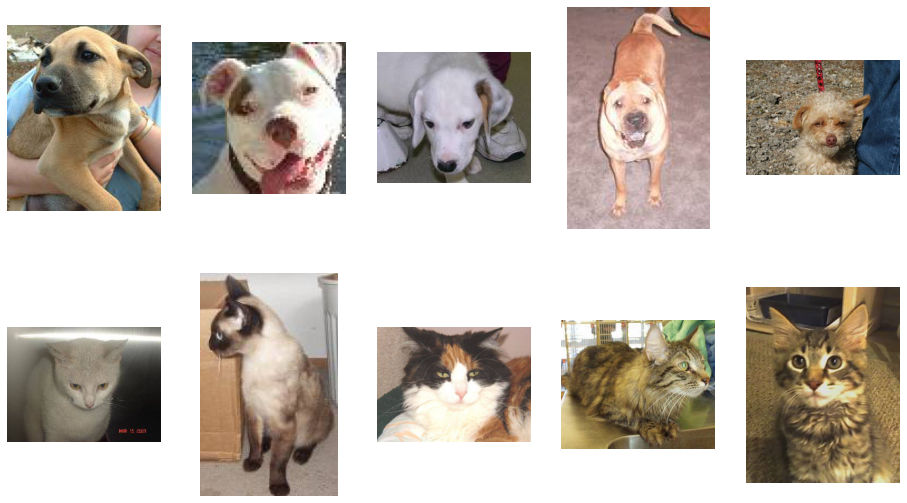

In [ ]:
random_idx = np.random.randint(1,len(train_list_init),size=10)

fig = plt.figure(figsize=[16,9])

for i, idx in enumerate(random_idx):
    ax = fig.add_subplot(2,5,i+1)
    ax.set_axis_off()  # https://stackoverflow.com/a/52776192/12224183
    img = PIL.Image.open(train_list_init[idx])
    plt.imshow(img)

Check the size of the images.

In [ ]:
num = len(train_list_init)
width_list = np.zeros(num)
height_list = np.zeros(num)
for i in tqdm.notebook.tqdm(range(num)):
    img = PIL.Image.open(train_list_init[i])
    width, height = img.size  # https://stackoverflow.com/a/6444612/12224183
    width_list[i] = width
    height_list[i] = height
print()
print(np.min(width_list), np.mean(width_list), np.max(width_list), np.std(width_list))
# 42.0 404.09904 1050.0 109.03574914255599
print(np.min(height_list), np.mean(height_list), np.max(height_list), np.std(height_list))
# 32.0 360.47808 768.0 97.01801894242945



42.0 404.09904 1050.0 109.035749142556
32.0 360.47808 768.0 97.01801894242945


## Define Transformations

In [ ]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    ])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    ])

test_transforms = torchvision.transforms.Compose([   
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor()
    ])

> - [Compose](https://pytorch.org/vision/stable/transforms.html#compositions-of-transforms): Composes several transforms together. This transform does not support torchscript. Please, see the note below.
- Resize: Resize the input image to the given size.
- RandomResizedCrop: Crop the given image to random size and aspect ratio.
- RandomHorizontalFlip: Horizontally flip the given image randomly with a given probability.
- ToTensor: Convert a PIL Image or numpy.ndarray to tensor. This transform does not support torchscript.
- [Examples](https://blog.csdn.net/see_you_yu/article/details/106722787)


## Create Dataset

Create a custom dataset for image data, see [Creating a Custom Dataset for your files](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files).

In [ ]:
class dataset(torch.utils.data.Dataset):
  
    def __init__(self,cache,transform=None):
        self.cache = cache
        self.transform = transform
        self.cache_length = len(self.cache)

    # dataset length
    def __len__(self):
        return self.cache_length
    
    # load an one of images
    def __getitem__(self,idx):
        img_transformed = self.transform(self.cache[idx][0])
        label = self.cache[idx][1]
        return img_transformed, label

In [ ]:
train_cache = [(PIL.Image.open(_), 1 if _.split('/')[-1].split('.')[0] == 'dog' else 0) for _ in train_list]
val_cache = [(PIL.Image.open(_), 1 if _.split('/')[-1].split('.')[0] == 'dog' else 0) for _ in val_list]
test_cache = [(PIL.Image.open(_), 1 if _.split('/')[-1].split('.')[0] == 'dog' else 0) for _ in test_list]

In [ ]:
train_data = dataset(train_cache, transform=train_transforms)
val_data = dataset(val_cache, transform=test_transforms)
test_data = dataset(test_cache, transform=test_transforms)
print(len(train_data[0]))
print(train_data[0][0].shape)  # check image shape
print(train_data[0])

2
torch.Size([3, 224, 224])
(tensor([[[0.2667, 0.2667, 0.2667,  ..., 0.2157, 0.1608, 0.1451],
         [0.2706, 0.2667, 0.2706,  ..., 0.2039, 0.1569, 0.1490],
         [0.2706, 0.2667, 0.2706,  ..., 0.1922, 0.1569, 0.1490],
         ...,
         [0.4588, 0.4667, 0.4824,  ..., 0.5020, 0.5176, 0.5059],
         [0.4627, 0.4627, 0.4824,  ..., 0.4824, 0.4902, 0.5176],
         [0.4588, 0.4667, 0.4902,  ..., 0.5020, 0.4941, 0.5098]],

        [[0.2784, 0.2784, 0.2784,  ..., 0.2157, 0.1647, 0.1490],
         [0.2824, 0.2784, 0.2824,  ..., 0.2078, 0.1608, 0.1529],
         [0.2824, 0.2784, 0.2824,  ..., 0.1961, 0.1608, 0.1529],
         ...,
         [0.4196, 0.4196, 0.4353,  ..., 0.4392, 0.4549, 0.4431],
         [0.4235, 0.4157, 0.4353,  ..., 0.4196, 0.4275, 0.4549],
         [0.4196, 0.4196, 0.4431,  ..., 0.4392, 0.4314, 0.4471]],

        [[0.2980, 0.2980, 0.2980,  ..., 0.2431, 0.1843, 0.1686],
         [0.3020, 0.2980, 0.3020,  ..., 0.2314, 0.1843, 0.1725],
         [0.3020, 0.2980, 0.3

## Create Data Loader

All datasets are subclasses of `torch.utils.data.Dataset` i.e, they have `__getitem__` and `__len__` methods implemented. Hence, they can all be passed to a `torch.utils.data.DataLoader` which can load multiple samples in parallel using `torch.multiprocessing` workers. See [TORCHVISION.DATASETS](https://pytorch.org/vision/stable/datasets.html?highlight=dataset#torchvision-datasets).

In [ ]:
batch_size = 100

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
print(train_loader)
print(val_loader)
print(test_loader)

In [ ]:
print(len(train_data), len(train_loader))
print(len(val_data), len(val_loader))
print(len(test_data), len(test_loader))

22500 225
2500 25
2500 25


# Build Model

In [ ]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,128, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(128,256, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(256,512, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*512,2048)
        self.dropout = nn.Dropout()
        self.fc2 = nn.Linear(2048,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# Training

In [ ]:
device

'cuda'

## Load Pretrained Model and Result if Exists

In [ ]:
model_dir = '/content/drive/MyDrive/kaggle-dogs-vs-cats-pytorch/model/'
models = os.listdir(model_dir)
print(models) # ['20210603083920.pt', '20210603084251.pt', '20210603084752.pt']

['20210604042420.pt', '20210604043149.pt', '20210604043918.pt', '20210604044645.pt', '20210604045401.pt', '20210604051700.pt', '20210604052126.pt', '20210604052833.pt', '20210604053540.pt', '20210604054248.pt', '20210604054955.pt', '20210604055700.pt', '20210604060408.pt', '20210604061121.pt', '20210604061847.pt', '20210604062606.pt', '20210604063323.pt', '20210604064040.pt', '20210604064757.pt', '20210604065520.pt', '20210604070242.pt', '20210604071222.pt', '20210604071944.pt', '20210604072702.pt', '20210604073423.pt', '20210604074143.pt', '20210604074907.pt', '20210604075631.pt', '20210604080356.pt', '20210604081128.pt', '20210604081904.pt']


In [ ]:
result_dir = '/content/drive/MyDrive/kaggle-dogs-vs-cats-pytorch/result/'
results = os.listdir(result_dir)
print(results)

['20210604042420.pkl', '20210604043149.pkl', '20210604043918.pkl', '20210604044645.pkl', '20210604045401.pkl', '20210604051700.pkl', '20210604052126.pkl', '20210604052833.pkl', '20210604053540.pkl', '20210604054248.pkl', '20210604054955.pkl', '20210604055700.pkl', '20210604060408.pkl', '20210604061121.pkl', '20210604061847.pkl', '20210604062606.pkl', '20210604063323.pkl', '20210604064040.pkl', '20210604064757.pkl', '20210604065520.pkl', '20210604070242.pkl', '20210604071222.pkl', '20210604071944.pkl', '20210604072702.pkl', '20210604073423.pkl', '20210604074143.pkl', '20210604074907.pkl', '20210604075631.pkl', '20210604080356.pkl', '20210604081128.pkl', '20210604081904.pkl']


In [ ]:
model_time_list = []
result_time_list = []
for m in models:
    model_time_list.append(int(m.split('.')[0]))
for r in results:
    result_time_list.append(int(r.split('.')[0]))
if model_time_list != [] and result_time_list != []:
    print('Successfully load pretrained model!')
    if max(model_time_list) == max(result_time_list):
        model = torch.load(model_dir + str(max(model_time_list)) + '.pt')  # load the latest model
        with open(result_dir + str(max(model_time_list)) + '.pkl', 'rb') as f:
            result = pickle.load(f)
    else:
        print('Max time does not match!')
else:
    print('No trained model! Initialize.')
    result = {'train_acc': [],
          'train_loss': [],
          'val_acc': [],
          'val_loss': []}
    model = cnn()
model = model.to(device)
print(model)
print(pprint.pprint(result))

Successfully load pretrained model!
cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4608, out_features=2048, bias=True)
  (dropout): Dropout(p=0

## Set Loss Function and Optimizer

In [ ]:
optimizer = optim.Adam(params = model.parameters(), lr=0.001)  # https://pytorch.org/docs/stable/optim.html
criterion = nn.CrossEntropyLoss()  # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

## Test Initial Network

Create a funtion for calculating average accuracy and loss of a data loader.

In [ ]:
def calc_acc_loss(loader, model, criterion):
    model.eval()
    acc = 0
    loss = 0
    with torch.no_grad():
        for data, label in tqdm.notebook.tqdm(loader):
            data = data.to(device)
            label = label.to(device)
            output = model(data)
            acc += ((output.argmax(dim=1) == label).float().mean())  # accuracy per image
            loss += criterion(output, label)  # loss per loader
    return acc/len(loader), loss/len(loader)

 Calculate accuracy and loss on test data using current network.

In [ ]:
acc, loss = calc_acc_loss(test_loader, model, criterion)  # it will take roughly 21 seconds on cpu
print(acc, loss)  # tensor(0.5056) tensor(0.6935)


tensor(0.9692, device='cuda:0') tensor(0.0741, device='cuda:0')


## Train Network

In [ ]:
epochs = 50
model.train()
for epoch in tqdm.notebook.tqdm(range(epochs)):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm.notebook.tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
    result['train_acc'].append(epoch_accuracy)
    result['train_loss'].append(epoch_loss)
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy, epoch_loss))
    
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
        
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            val_loss = criterion(val_output,label)

            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
        result['val_acc'].append(epoch_val_accuracy)
        result['val_loss'].append(epoch_val_loss)
        print('Epoch : {}, val accuracy : {}, val loss : {}'.format(epoch+1, epoch_val_accuracy, epoch_val_loss))
    
    # save model and result in case Colab crack
    if epoch % 5 == 0:
        timestr = time.strftime('%Y%m%d%H%M%S')
        torch.save(model, model_dir + timestr + '.pt')
        with open(result_dir + timestr + '.pkl', 'wb') as f:
            pickle.dump(result, f)

Show final result of test data splitted from training data.

In [ ]:
acc, loss = calc_acc_loss(test_loader, model, criterion)  # it will take roughly 21 seconds on cpu
print(acc, loss)


tensor(0.9264, device='cuda:0') tensor(0.1724, device='cuda:0')


## Training Curve

[Secondary axis with twinx(): how to add to legend?](https://stackoverflow.com/a/5487005/12224183)

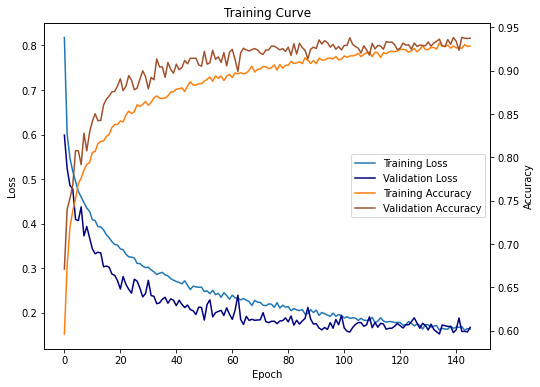

In [ ]:
fig, ax = plt.subplots(figsize=[8,6])

line1 = ax.plot(result['train_loss'], label='Training Loss', color='tab:blue')
line2 = ax.plot(result['val_loss'], label='Validation Loss', color='navy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Curve')

ax2 = ax.twinx()
line3 = ax2.plot(result['train_acc'], label='Training Accuracy', color='tab:orange')
line4 = ax2.plot(result['val_acc'], label='Validation Accuracy', color='sienna')
ax2.set_ylabel('Accuracy')

lines = line1 + line2 + line3 + line4
labels = [_.get_label() for _ in lines]
ax.legend(lines, labels, loc='center right')

## Save Model and Result

Save the model to OneDrive in case of further training, see [SAVING AND LOADING MODELS](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-and-loading-models).

Name extension '.pt' of file, see [TORCH.SAVE](https://pytorch.org/docs/stable/generated/torch.save.html).

[How to create a file name with the current date & time in Python?](https://stackoverflow.com/questions/10607688/how-to-create-a-file-name-with-the-current-date-time-in-python)

[How can I use pickle to save a dict?](https://stackoverflow.com/questions/11218477/how-can-i-use-pickle-to-save-a-dict)

In [ ]:
timestr = time.strftime('%Y%m%d%H%M%S')
torch.save(model, model_dir + timestr + '.pt')
with open(result_dir + timestr + '.pkl', 'wb') as f:
    pickle.dump(result, f)

# Test

Factorization an integer into the two closest integers so as to determine subplot size using length of test images, see [Factorization into the two closest integers](https://stackoverflow.com/questions/16266931/input-an-integer-find-the-two-closest-integers-which-when-multiplied-equal-th).

In [ ]:
def factorize(n):
    temp = math.floor(math.sqrt(n))
    while n % temp != 0:
        temp -= 1
    return temp, int(n / temp)

factorize(8)  # (2, 4)

(2, 4)

In [ ]:
def visualize(name):
    fig = plt.figure()
    fig.suptitle(str(name).title() + ' Test')
    model.eval()
    path = '/content/drive/MyDrive/kaggle-dogs-vs-cats-pytorch/data/' + name + '/'
    mytest_list = [path + _ for _ in os.listdir(path)]
    mytest_num = len(mytest_list)
    height, width = factorize(mytest_num)
    mytest_cache = [(PIL.Image.open(_), _.split('/')[-1].split('.')[0]) for _ in mytest_list]
    mytest_data = dataset(mytest_cache, transform=test_transforms)

    with torch.no_grad():
        for i, _ in enumerate(mytest_data):
            data, _ = torch.utils.data.DataLoader(dataset=_)
            if data.shape[1] == 4:  # '.png' images have 4 channels
                data = data[:,:3,:,:]
            data = data.to(device)  # shape: torch.Size([1, 3, 224, 224])
            pred = model(data)  # tensor([[-1.2971, -0.2252]], device='cuda:0')
            pred = F.softmax(pred, dim=1)[:, 1][0]
            ax = fig.add_subplot(height, width, i+1)
            ax.set_axis_off()  # https://stackoverflow.com/a/52776192/12224183
            plt.imshow(mytest_cache[i][0])
            ax.set_title('{}% dog'.format(int(pred*100)) if pred > 0.5 else '{}% cat'.format(int(100*(1-pred))))


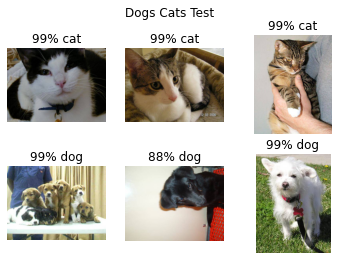

In [ ]:
visualize('dogs-vs-cats')

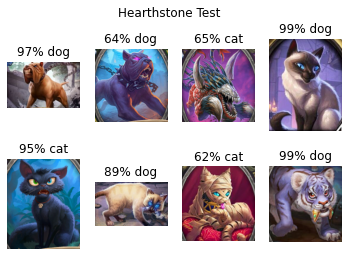

In [ ]:
visualize('hearthstone')

# Remaining

The remaining part is for the generation of submission files, leaving **the same as the origin notebook**.

As mensioned above, it seems that we cannot successfully submit results in Kaggle.

Thus, if we only use test data splitted from training data, we can ignore the remaining codes in [Image Classification with Pytorch](https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/)